# Libraries

In [329]:
import numpy as np
import matplotlib.pyplot as plt
import librosa

# Download Datasets

In [330]:
from dataset_downloader import DatasetDownloader
dataset_downloader = DatasetDownloader()

#------------------------------------------------
# Remove the commenting below to download the dataset
#------------------------------------------------

#dataset_downloader.download_datasets("datasets/path_files/download_paths_2025.yaml")

# Code

## Short-Time Fourier Transform (STFT)

In [331]:
#> load audio files
file_path = "datasets/DCASE2025T2/ToyCar/Development/ToyCar/train/section_00_source_train_normal_0001_car_B1_spd_31V_mic_1.wav"
amplitude, sampling_rate = librosa.load(file_path, sr=None, mono=True)

In [332]:
#> setup of acoustic features
frame_size_time = 0.064 #64ms
frame_size_samples = int(frame_size_time * sampling_rate)
hop_size_samples = frame_size_samples // 2
window_size_samples = frame_size_samples

mel_energies = 128
number_of_frames_to_concatenate = 5

number_of_input_features = mel_energies * number_of_frames_to_concatenate
print("Number of input features: ", number_of_input_features)

Number of input features:  640


In [333]:
print(f"Sampling Rate:\t{sampling_rate} samples per second")
print(f"Frame Size:\t{frame_size_time} seconds ({frame_size_time * 1000} ms) = {frame_size_samples} samples")
#print(f"Samples per Frame:\t{samples_per_frame}")
#print(f"Hop Size:\t\t{hop_size} samples ({1 / (samples_per_frame / hop_size) * 100} %)")
print(f"Hop Size:\t{hop_size_samples / sampling_rate} seconds ({hop_size_samples / sampling_rate * 1000} ms) =  {hop_size_samples} samples")

Sampling Rate:	16000 samples per second
Frame Size:	0.064 seconds (64.0 ms) = 1024 samples
Hop Size:	0.032 seconds (32.0 ms) =  512 samples


In [334]:
#> apply stft
# stft = librosa.stft(amplitude, n_fft=frame_size_samples, hop_length=hop_size_samples, win_length=window_size_samples)

### Mel Spectrogram

In [335]:
mel_spectrogram = librosa.feature.melspectrogram(
    y=amplitude,
    sr=sampling_rate,
    n_fft=frame_size_samples,
    hop_length=hop_size_samples,
    n_mels=mel_energies
)
mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
mel_spectrogram

array([[-21.359037 , -35.270405 , -33.58871  , ..., -34.853172 ,
        -34.358654 , -18.505054 ],
       [-18.272736 , -22.502966 , -23.040703 , ..., -24.40292  ,
        -21.911257 , -17.48298  ],
       [-12.149305 , -18.131866 , -16.138865 , ..., -16.054533 ,
        -15.990406 , -13.2293005],
       ...,
       [-59.007317 , -59.61678  , -58.09847  , ..., -56.816147 ,
        -56.809288 , -56.884476 ],
       [-60.221134 , -62.160183 , -61.113148 , ..., -57.911407 ,
        -59.06407  , -59.610184 ],
       [-64.69079  , -74.589165 , -77.60099  , ..., -72.74041  ,
        -75.19541  , -74.427025 ]], shape=(128, 376), dtype=float32)

In [336]:
number_of_frames = mel_spectrogram.shape[1]

print(f"Number of Mel Energies:\t{mel_energies}")
print(f"Number of Frames:\t{number_of_frames}")

Number of Mel Energies:	128
Number of Frames:	376


In [337]:
input_features = []
for i in range(number_of_frames - number_of_frames_to_concatenate + 1): # 376 - 5 + 1 = 372
    concatenated_segment = mel_spectrogram[:, i:i + number_of_frames_to_concatenate].flatten()
    input_features.append(concatenated_segment)

input_features = np.array(input_features)
input_features.shape

(372, 640)

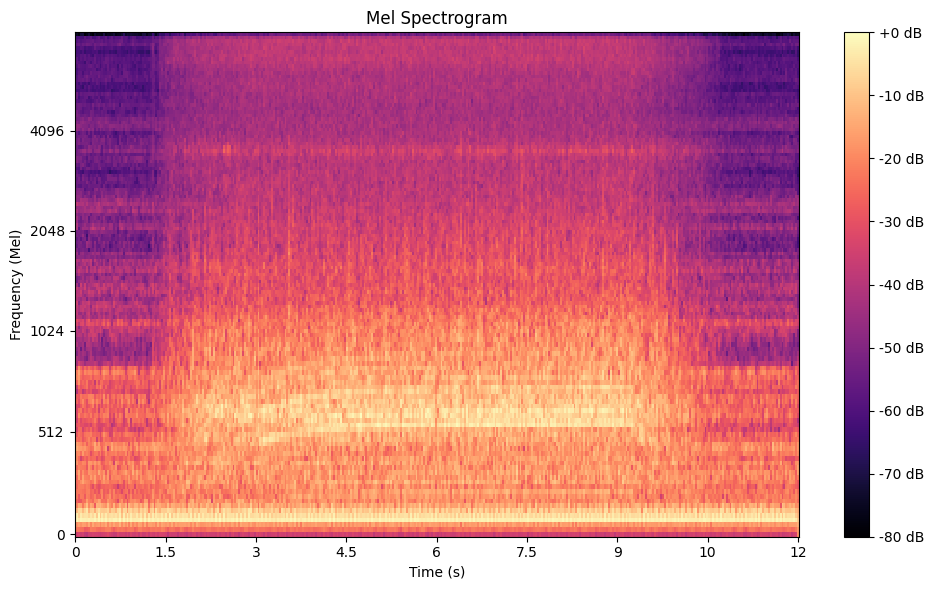

In [338]:
plt.figure(figsize=(10, 6))
librosa.display.specshow(mel_spectrogram, sr=sampling_rate, hop_length=hop_size_samples, x_axis='time', y_axis='mel', cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title("Mel Spectrogram")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Mel)")
plt.tight_layout()
plt.show()

## Autoencoder

### Preparing Data

In [339]:
import torch
import torch.nn as nn
import torch.optim as optimizer
from autoencoder import Autoencoder
from torch.utils.data import DataLoader

In [340]:
input_features.shape

(372, 640)

In [341]:
dataset = torch.tensor(input_features, dtype=torch.float32)
train_loader = DataLoader(dataset, batch_size=256, shuffle=True)

In [342]:
train_loader

### Setting up Model

In [343]:
device = torch.device("cude" if torch.cuda.is_available() else "cpu")
model = Autoencoder().to(device)
criterion = nn.MSELoss()
my_optimizer = optimizer.Adam(model.parameters(), lr=0.001)
number_of_epochs = 100

### Training

In [ ]:
def train_model():
    for epoch in range(number_of_epochs):
        model.train()
        total_loss = 0

        for data in train_loader:
            print(data.shape)
            data = data.to(device)
            my_optimizer.zero_grad()

            #> forward pass
            output = model(data)
            loss = criterion(output, data)

            #> backward pass
            loss.backward()
            my_optimizer.step()
            total_loss += loss.item()

        average_loss = total_loss / len(train_loader)
        print(f"Epoch [{epoch + 1}/{number_of_epochs}], Loss: {average_loss:.4f}")

    model.eval()
    with torch.no_grad():
        sample = dataset[0].unsqueeze(0).to(device)
        reconstruction = model(sample)

    print("Original:", sample.cpu().numpy())
    print("Reconstructed:", reconstruction.cpu().numpy())

In [345]:
train_model()

torch.Size([256, 640])
torch.Size([116, 640])
Epoch [1/100], Loss: 1283.1664
torch.Size([256, 640])
torch.Size([116, 640])
Epoch [2/100], Loss: 1271.2168
torch.Size([256, 640])
torch.Size([116, 640])
Epoch [3/100], Loss: 1256.7936
torch.Size([256, 640])
torch.Size([116, 640])
Epoch [4/100], Loss: 1248.2947
torch.Size([256, 640])
torch.Size([116, 640])
Epoch [5/100], Loss: 1232.6631
torch.Size([256, 640])
torch.Size([116, 640])
Epoch [6/100], Loss: 1226.7623
torch.Size([256, 640])
torch.Size([116, 640])
Epoch [7/100], Loss: 1239.6154
torch.Size([256, 640])
torch.Size([116, 640])
Epoch [8/100], Loss: 1212.6591
torch.Size([256, 640])
torch.Size([116, 640])
Epoch [9/100], Loss: 1207.0626
torch.Size([256, 640])
torch.Size([116, 640])
Epoch [10/100], Loss: 1197.6583
torch.Size([256, 640])
torch.Size([116, 640])
Epoch [11/100], Loss: 1182.1684
torch.Size([256, 640])
torch.Size([116, 640])
Epoch [12/100], Loss: 1174.8593
torch.Size([256, 640])
torch.Size([116, 640])
Epoch [13/100], Loss: 1155.